In [1]:
import riiideducation # enviorment
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb # light gradient boosting model
import dask.dataframe as dd # dask fast dataframe importer
from sklearn.metrics import roc_auc_score # area under the curve calculator
from sklearn.preprocessing import LabelEncoder # label encoder
import matplotlib.pyplot as plt # plotting

import gc 
import os 
import sys


training_path           = '/kaggle/input/riiid-test-answer-prediction/train.csv'
questions_path          = '/kaggle/input/riiid-test-answer-prediction/questions.csv'
lectures_path           = '/kaggle/input/riiid-test-answer-prediction/lectures.csv'
example_submission_path = '/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv'
example_test_path       = '/kaggle/input/riiid-test-answer-prediction/example_test.csv'

In [2]:
"""
Print the paths for local enviorment input files.
"""
def print_paths():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            

"""
Print the input string to the notebook console. 
Also prints the input string to Kaggle kenrel.
"""
def print_log(s):
    print(s)
    sys.__stdout__.write(s)
    

"""
Convert the existing dataframe values to data types.
Also replace NaN values with -1. 
Returns the dataframes for training as well as labels.
"""    
def getDataFramesForTraining(dataframe):
    data = dataframe[features]
    data['prior_question_elapsed_time'].fillna(-1, inplace=True)
    return data, dataframe['answered_correctly']


"""
Convert the existing dataframe values to data types.
Also replace NaN values with -1. 
Returns the dataframes for testing.
"""
def getDataFramesForTesting(dataframe):
    data = dataframe[features]
    data['prior_question_elapsed_time'].fillna(-1, inplace=True)
    return data


"""
Convert the existing dataframe values to correct data types.
Splice tag column into multiple columns and append them to questions dataframe.
Returns the dataframes for questions.
"""
def getDataFramesForQuestions(dataframe):
    tag = dataframe["tags"].str.split(" ", n = 10, expand = True) 
    tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
    dataframe =  pd.concat([dataframe,tag], axis=1)
    for tag in tag.columns:
        dataframe[tag] = pd.to_numeric(dataframe[tag], errors='coerce')
    return dataframe

"""
Merge in the questions tag columns joining
on question_id and content_id.
Return the merged dataframe.
"""
def mergeQuestions(train, questions):
    return pd.merge(train, questions, left_on = 'content_id', right_on = 'question_id', how = 'left') 


"""

"""
def encodeColumns(dataframe):
    lb_make = LabelEncoder()
    dataframe['prior_question_had_explanation'].fillna(True, inplace=True)
    dataframe["prior_question_had_explanation_enc"] = lb_make.fit_transform(dataframe["prior_question_had_explanation"])
    return dataframe


"""

"""
def expandTags(questions):
    tag = questions["tags"].str.split(" ", n = 10, expand = True) 
    tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
    questions =  pd.concat([questions,tag],axis=1)
    for tag in tag.columns:
        questions[tag] = pd.to_numeric(questions[tag], errors='coerce')
    return questions


"""

"""
def plot_metrics(model, eval_results):
    lgb.plot_importance(model)
    plt.show()
    metrics = ['auc', 'l1', 'l2']
    for metric in metrics: 
        lgb.plot_metric(eval_results, metric=metric)
        plt.show()
        

"""

"""
def createSubmission(model):
    env = riiideducation.make_env()
    for test_df, sample_prediction_df in env.iter_test():
        test_df_enc = encodeColumns(test_df)
        test_df_enc = mergeQuestions(test_df_enc, questions)
        testdata = getDataFramesForTesting(test_df_enc)
        test_df['answered_correctly'] =  model.predict(testdata[features])
        env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])
        

"""

"""
def splitTrainValid(train, labels):
    trainingCount = int(len(labels.index) * training_valid_ratio)
    train_dataset = lgb.Dataset(train[:trainingCount], labels[:trainingCount], categorical_feature = categorical_features)
    valid_dataset = lgb.Dataset(train[trainingCount:], labels[trainingCount:], categorical_feature = categorical_features)
    return train_dataset, valid_dataset

In [3]:
features = ['content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation_enc', 'tags1','tags2','tags3','tags4']
categorical_features = ['tags1','tags2','tags3','tags4']

training_cols = ['content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'answered_correctly']
question_cols = [0, 1, 3, 4]

training_dtype = {'content_id': 'int16','content_type_id': 'int8','answered_correctly':'int8','prior_question_elapsed_time': 'float32','prior_question_had_explanation': 'boolean'}
question_dtype = {'question_id': 'int16', 'part': 'int8','bundle_id': 'int8','tags': 'str'}

million = 1000000
training_valid_ratio = 0.9
max_iterations = 1000
eval_round = 10
eval_results = {}

training_params = {'objective'            : 'binary',
                   'metric'               :('auc', 'l1', 'l2'),
                   'boosting'             : 'gbdt',
                   'tree_learner'         : 'voting',
                   'learning_rate'        :  0.11,
                   'num_leaves'           :  80,
                   'min_data_in_leaf'     :  20,
                   'early_stopping_rounds':  10}

In [4]:
train = pd.read_csv(training_path, nrows=60*million, engine='c', usecols=training_cols, dtype=training_dtype)

gc.collect()
print_log('Done reading training data.')

Done reading training data.


In [5]:
questions = pd.read_csv(questions_path, usecols=question_cols, dtype=question_dtype)

gc.collect()
print_log('Done reading questions data.')

Done reading questions data.


In [6]:
questions = expandTags(questions)

gc.collect()
print_log('Done grabbing tags.')

Done grabbing tags.


In [7]:
train = mergeQuestions(train, questions)

gc.collect()
print_log('Done merging questions.')

Done merging questions.


In [8]:
train = encodeColumns(train)

gc.collect()
print_log('Done encoding columns.')

Done encoding columns.


In [9]:
train, labels = getDataFramesForTraining(train)

gc.collect()
print_log('Done labelling data.')

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Done labelling data.


In [10]:
train_dataset, valid_dataset = splitTrainValid(train, labels)

gc.collect()
print_log('Done splitting training and valid.')

Done splitting training and valid.


In [11]:
model = lgb.train(training_params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=max_iterations, verbose_eval=eval_round, evals_result=eval_results)

gc.collect()
print_log('Done training.')

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.652122	training's l1: 0.451039	training's l2: 0.238438	valid_1's auc: 0.652048	valid_1's l1: 0.451266	valid_1's l2: 0.238288
[20]	training's auc: 0.660008	training's l1: 0.441504	training's l2: 0.229995	valid_1's auc: 0.659798	valid_1's l1: 0.441861	valid_1's l2: 0.229977
[30]	training's auc: 0.666795	training's l1: 0.437069	training's l2: 0.226771	valid_1's auc: 0.666564	valid_1's l1: 0.43748	valid_1's l2: 0.226794
[40]	training's auc: 0.671001	training's l1: 0.434847	training's l2: 0.225328	valid_1's auc: 0.670717	valid_1's l1: 0.435279	valid_1's l2: 0.225369
[50]	training's auc: 0.675229	training's l1: 0.433232	training's l2: 0.224353	valid_1's auc: 0.674938	valid_1's l1: 0.433672	valid_1's l2: 0.224397
[60]	training's auc: 0.678835	training's l1: 0.431967	training's l2: 0.223623	valid_1's auc: 0.678529	valid_1's l1: 0.432417	valid_1's l2: 0.223671
[70]	training's auc: 0.681724	training's l1: 0.43092

In [12]:
createSubmission(model)
    
gc.collect()    
print_log('Done with inference.')

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Done with inference.


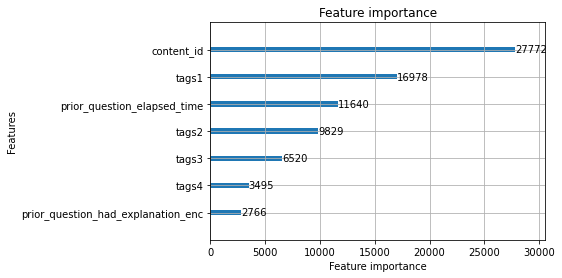

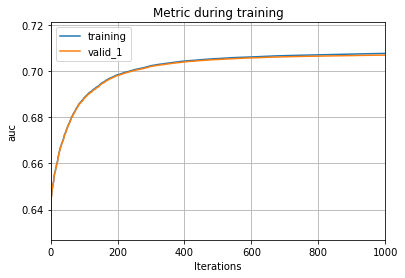

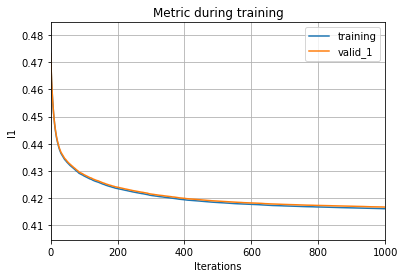

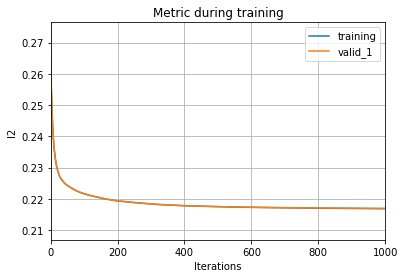

Done all.


In [13]:
plot_metrics(model, eval_results)

gc.collect()
print_log('Done all.')